In [1]:
import os, sys, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scFates as scf
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE136689'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_unzip = os.path.join(pth_data, 'unzip', geo)
pth_out = os.path.join(pth_data, 'processed')
pth_fig = os.path.join(pth, 'figures', 'preprocessing')

In [3]:
df_summary = pd.read_csv(os.path.join(pth_data, 'summary.csv'))
df_summary = df_summary.loc[df_summary.Source == geo]
df_summary

,Source,Name,Study,Species,Trajectory,Age,Description
0,GSE136689,Splanchnic Mesoderm,"Han et al., 2020",mmusculus,True,E8.5-9.5,Foregut organogenesis dataset showing interact...


In [ ]:
counts_fn = glob.glob(os.path.join(pth_unzip, '*Counts*.txt'))[0]
df_fn = glob.glob(os.path.join(pth_unzip, '*MetaFile*.txt'))[0]
adata = sc.read_text(counts_fn).T
df = pd.read_csv(df_fn, sep = '\t', index_col = 0)
adata.obs = df.iloc[:, 1:].astype('category')
adata.X = csr_matrix(adata.X); adata

AnnData object with n_obs × n_vars = 14545 × 27774
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations'

In [6]:
adata = adata[adata.obs.Type == 'Mesoderm'].copy()
adata

AnnData object with n_obs × n_vars = 10097 × 27774
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations'

In [7]:
sc.pp.normalize_total(adata, target_sum = 10000)
sc.pp.log1p(adata)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 2050 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



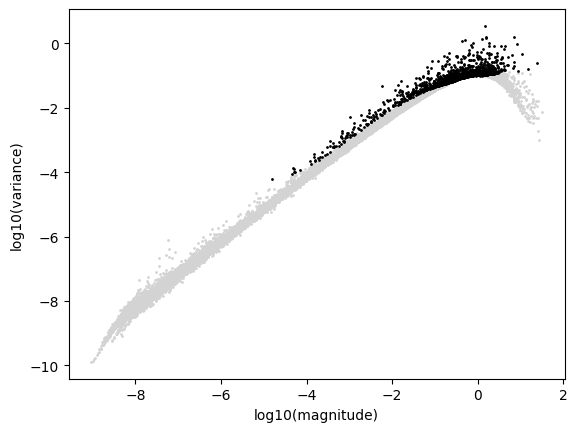

In [8]:
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [9]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'Stages', max_iter_harmony = 1)

2025-10-12 22:41:33,516 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-12 22:41:36,441 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-12 22:41:36,500 - harmonypy - INFO - Iteration 1 of 1
2025-10-12 22:41:40,029 - harmonypy - INFO - Stopped before convergence


In [10]:
sc.pp.neighbors(adata, n_pcs = 20, use_rep = 'X_pca_harmony')

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sc.tl.draw_graph(adata)

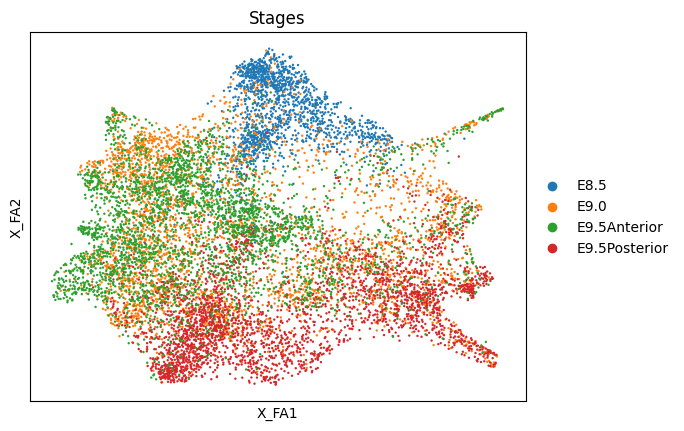

In [12]:
basis = 'X_draw_graph_fa'
sc.pl.embedding(adata, basis, color = 'Stages')

In [13]:
celltype_dict = {
    'pharyngeal mesoderm 1'             : 'Pharynx',
    'pharyngeal mesoderm 2 (posterior)' : 'Pharynx',
    'phanryngeal mesoderm 3'            : 'Pharynx',
    'pharyngeal 4'                      : 'Pharynx',
    'pharyngeal mesoderm 5'             : 'Pharynx',
    'esophagus'                         : 'Esophagus',
    'respiratory'                       : 'Respiratory',
    'outflow tract '                    : 'Outflow Tract',
    ' stomach 1 '                       : 'Stomach',
    ' stomach 2 (ventral)'              : 'Stomach',
    'stomach 3'                         : 'Stomach',
    'duodenum'                          : 'Duodenum',
    'sinus venosus'                     : 'Liver',
    'liver-septum transversum'          : 'Liver',
    'mesothelium 1 (liver)'             : 'Liver',
    'mesothelium 2'                     : 'Liver',
    'fibroblast 1 (near liver)'         : 'Liver'}

msk_early = (adata.obs.Stages == 'E8.5') & ~adata.obs.LineageAnnotations.isin(celltype_dict)
adata.obs['celltype'] = adata.obs.LineageAnnotations.map(celltype_dict).astype('category')
adata.obs['celltype'] = adata.obs.celltype.cat.add_categories(['Splanchnic Mesoderm'])
adata.obs.loc[msk_early, 'celltype'] = 'Splanchnic Mesoderm'

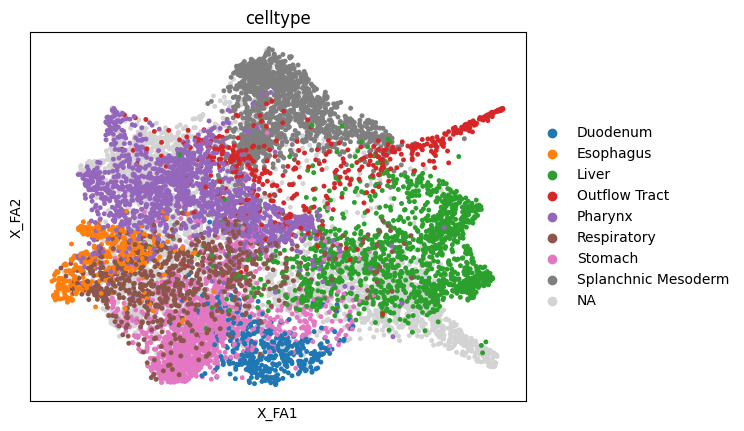

In [14]:
sc.pl.embedding(adata, basis, color = 'celltype', size = 50)

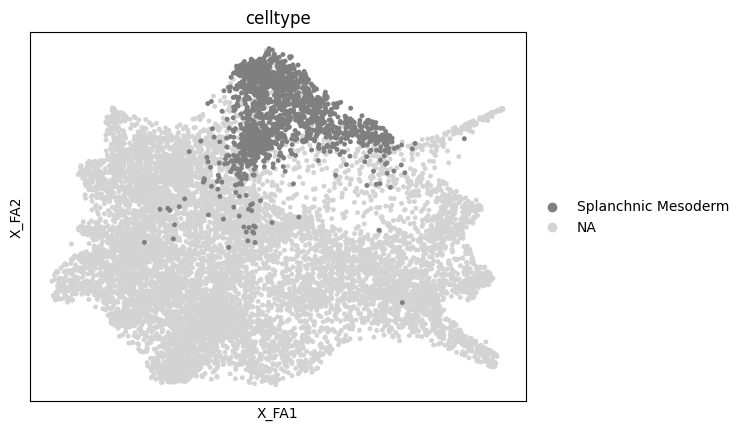

In [15]:
sc.pl.embedding(adata, basis, color = 'celltype', groups = ['Splanchnic Mesoderm'], size = 50)

In [16]:
adata.write(os.path.join(pth_out, f'{geo}.h5ad'))

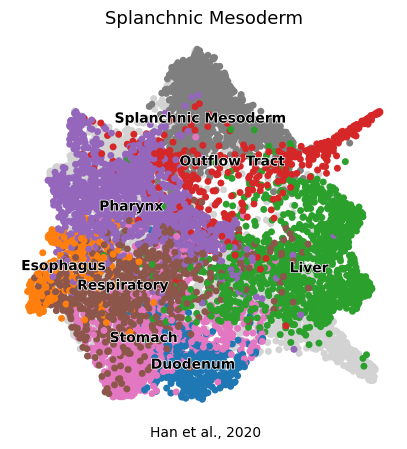

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata, basis, color = 'celltype', size = 100,
                legend_loc = 'on data', na_in_legend = False,
                legend_fontoutline = 1, frameon = False,
                show = False, ax = ax)
ax.set_title(df_summary.Name.values[0], size = 13)
ax.text(.36, -.05, df_summary.Study.values[0], transform = ax.transAxes)
fn = os.path.join(pth_fig, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')